In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [55]:
df = pd.read_csv(r"D:\Coding\Major-Project\new_\data\preprocessed_data.csv")

In [56]:
X = df[["I","P","Q","T","Hydrogen","Oxygen","RH anode","Rh Cathode"]].values
y = df["V"].values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
base_learners_baseline = [
    ("enet", make_pipeline(StandardScaler(), ElasticNet(max_iter=5000))),
    ("svr",  make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, epsilon=0.1))),
    ("knn",  make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=7))),
    ("gbr",  GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)),
]

In [59]:
meta = RidgeCV(alphas=np.logspace(-4, 4, 25))

In [60]:
stack_baseline = StackingRegressor(
    estimators=base_learners_baseline,
    final_estimator=meta,
    cv=5,
    passthrough=False
)

In [61]:
stack_baseline.fit(X_train, y_train)
y_pred_base = stack_baseline.predict(X_test)

In [62]:
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

In [63]:
print("\n===== Baseline Stack =====")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²:   {r2_base:.4f}")
print(f"MAE:  {mae_base:.4f}")


===== Baseline Stack =====
RMSE: 0.9310
R²:   0.9998
MAE:  0.5017


In [ ]:
print("\n===== Meta-Learner Parameters =====")
print(f"Optimal Lambda (λ): {lambda_val:.4f}\n")
print(f"Intercept (β₀): {beta_0:.4f}")
print(f"Weight for SVR (β₁): \t{beta_coeffs[0]:.4f}")
print(f"Weight for ElasticNet (β₂): {beta_coeffs[1]:.4f}")
print(f"Weight for GBR (β₃): \t{beta_coeffs[2]:.4f}")
print(f"Weight for KNN (β₄): \t{beta_coeffs[3]:.4f}")

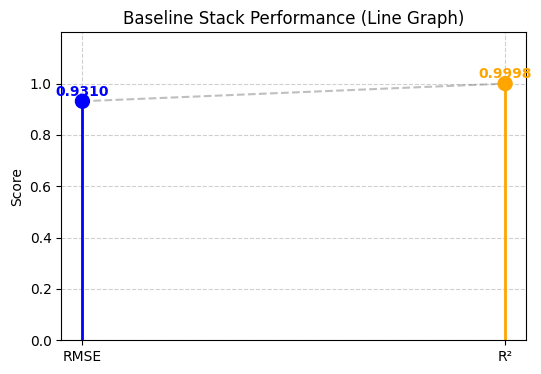

In [64]:
# Line graph for Baseline Stack: Blue for RMSE, Orange for R²
import matplotlib.pyplot as plt

metrics = ['RMSE', 'R²']
values = [rmse_base, r2_base]
colors = ['blue', 'orange']

plt.figure(figsize=(6, 4))
plt.plot([metrics[0], metrics[0]], [0, values[0]], color='blue', linewidth=2)
plt.plot([metrics[1], metrics[1]], [0, values[1]], color='orange', linewidth=2)
plt.scatter(metrics, values, color=colors, s=100, zorder=5)
plt.plot(metrics, values, color='gray', linestyle='--', alpha=0.5)

plt.title('Baseline Stack Performance (Line Graph)')
plt.ylabel('Score')
plt.ylim(0, max(values) * 1.2)

# Annotate points
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.4f}', color=colors[i], ha='center', va='bottom', fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [65]:
# Improved Stack (with XGB + passthrough)

base_learners_improved = [
    ("enet", make_pipeline(StandardScaler(), ElasticNet(max_iter=5000))),
    ("svr",  make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, epsilon=0.1))),
    ("knn",  make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=7))),
    ("xgb",  XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3,
                           random_state=42, verbosity=0)),
]

NameError: name 'XGBRegressor' is not defined

In [ ]:
stack_improved = StackingRegressor(
    estimators=base_learners_improved,
    final_estimator=meta,
    cv=5,
    passthrough=True   # Let meta-learner see original features + preds
)

In [ ]:
stack_improved.fit(X_train, y_train)
y_pred_imp = stack_improved.predict(X_test)

In [ ]:
rmse_imp = np.sqrt(mean_squared_error(y_test, y_pred_imp))
r2_imp = r2_score(y_test, y_pred_imp)
mae_imp = mean_absolute_error(y_test, y_pred_imp)

In [ ]:
print("\n===== Improved Stack (XGB + passthrough) =====")
print(f"RMSE: {rmse_imp:.4f}")
print(f"R²:   {r2_imp:.4f}")
print(f"MAE:  {mae_imp:.4f}")


===== Improved Stack (XGB + passthrough) =====
RMSE: 1.0656
R²:   0.9997
MAE:  0.6044


In [ ]:
# Extra: Cross-validated RMSE

scores_base = cross_val_score(stack_baseline, X, y, cv=5,
                              scoring="neg_root_mean_squared_error")
scores_imp = cross_val_score(stack_improved, X, y, cv=5,
                             scoring="neg_root_mean_squared_error")

print("\n===== Cross-Validation RMSE =====")
print(f"Baseline Stack CV RMSE: {-scores_base.mean():.4f}")
print(f"Improved Stack CV RMSE: {-scores_imp.mean():.4f}")



===== Cross-Validation RMSE =====
Baseline Stack CV RMSE: 21.1786
Improved Stack CV RMSE: 49.1663


In [ ]:
import joblib

# Save the trained stacking model
joblib.dump(stack_improved, "stacking_model.pkl")

['stacking_model.pkl']